In [1]:
import pickle
import os, sys
import numpy as np
os.chdir('../src')  # to avoid importing utils Anaconda package
from parameters import *
from plot_utils import *
from TDLambda_Home2Rwd_model import TDLambda_Home2Rwd

In [2]:
model = TDLambda_Home2Rwd()

In [3]:
sub_fits = {0:[0.1,3,0.9,0.5]}

In [ ]:
REPEATS = 2
N = len(sub_fits)
S = 129
avg_state_value_hist = [np.zeros(S)]*N
total_pred_traj = [[]*N] 

for i in np.arange(REPEATS):
    pred_traj, state_value_hist = model.simulate(sub_fits)
    
    for mouseID in state_value_hist:
        avg_state_value_hist[mouseID] = avg_state_value_hist[mouseID] + state_value_hist[mouseID]
        
    for mouseID in pred_traj:
        for traj in pred_traj[mouseID]:
            total_pred_traj[mouseID].extend(traj)
        
for mouseID in sub_fits:
    avg_state_value_hist[mouseID] /= REPEATS

In [5]:
# # Plotting frequency of predicted states
# mouseID = 0
# plot_maze_stats(total_pred_traj[mouseID], 'states')

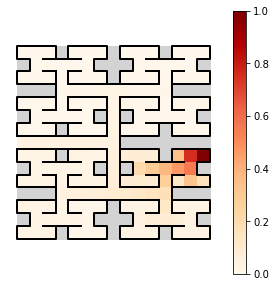

In [9]:
data = avg_state_value_hist[0]
plot_maze_stats(data, 'state_values', 'OrRd')